# Aggregation

In [1]:
# be sure to restart
!pip install sqlparse

In [2]:
import pandas as pd
from dfply import *

## What is aggregation?

The act of collapsing many rows into few rows.

## Example - Baseball pitching

#### `pandas`

In [3]:
pitching_raw = pd.read_csv('./data/baseball/core/Pitching.csv') 
pitching = (pitching_raw >>
             mutate(id = pitching_raw.index))
pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,id
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,7,NaN,0,146.0,0,42,NaN,NaN,NaN,0
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,7,NaN,0,1291.0,0,292,NaN,NaN,NaN,1
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,2,NaN,0,14.0,0,9,NaN,NaN,NaN,2
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,20,NaN,0,1080.0,1,257,NaN,NaN,NaN,3
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,0,NaN,0,57.0,0,21,NaN,NaN,NaN,4


In [4]:
pitching.dtypes

playerID     object
yearID        int64
stint         int64
teamID       object
lgID         object
W             int64
L             int64
G             int64
GS            int64
CG            int64
SHO           int64
SV            int64
IPouts        int64
H             int64
ER            int64
HR            int64
BB            int64
SO            int64
BAOpp       float64
ERA         float64
IBB         float64
WP            int64
HBP         float64
BK            int64
BFP         float64
GF            int64
R             int64
SH          float64
SF          float64
GIDP        float64
id            int64
dtype: object

#### `sqlalchemy`

In [5]:
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import select as select_sql

pitching_eng = create_engine("sqlite:///databases/baseball_2_5.db") 
Base = automap_base()
Base.prepare(pitching_eng, reflect=True)
Pitching = Base.classes.pitching
Pitching

sqlalchemy.ext.automap.pitching

In [6]:
stmt = select_sql('*').select_from(Pitching).limit(5)
pd.read_sql_query(stmt, con=pitching_eng)

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,id
0,bechtge01,1871,1,PH1,None,1,2,3,3,2,...,7,None,0,146.0,0,42,None,None,None,0
1,brainas01,1871,1,WS3,None,12,15,30,30,30,...,7,None,0,1291.0,0,292,None,None,None,1
2,fergubo01,1871,1,NY2,None,0,0,1,0,0,...,2,None,0,14.0,0,9,None,None,None,2
3,fishech01,1871,1,RC1,None,4,16,24,24,22,...,20,None,0,1080.0,1,257,None,None,None,3
4,fleetfr01,1871,1,NY2,None,0,1,1,1,1,...,0,None,0,57.0,0,21,None,None,None,4


#### `pyspark`

In [7]:
import spark
print(spark.version)
import pyspark
print(pyspark.__version__)

ModuleNotFoundError: No module named 'spark'

In [8]:
from pyspark.sql import SparkSession
from more_pyspark import get_spark_types, to_pandas

spark = SparkSession.builder.appName('Ops').getOrCreate()

schema = get_spark_types(pitching, keys=['id'])

pitching_spark = spark.createDataFrame(pitching, schema=schema)
#pitching_raw = spark.read.csv('./data/baseball/core/Pitching.csv', schema=schema) 

(pitching_spark.
   take(5)) >> to_pandas

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,id
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,7,NaN,0,146.0,0,42,NaN,NaN,NaN,0
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,7,NaN,0,1291.0,0,292,NaN,NaN,NaN,1
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,2,NaN,0,14.0,0,9,NaN,NaN,NaN,2
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,20,NaN,0,1080.0,1,257,NaN,NaN,NaN,3
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,0,NaN,0,57.0,0,21,NaN,NaN,NaN,4


## Simple Aggregation

A **simple aggregation** collapses all rows into one row.

<img src="./img/simple_aggregation.png" width=800>

## Simple aggregation with `dfply.summarise`

In [9]:
(pitching >>
  summarise(mean_era = mean(X.ERA),
            sd_era = sd(X.ERA),
            max_wins = X.W.max(),
            min_wins = X.W.min()))

,mean_era,sd_era,max_wins,min_wins
0,5.084865,5.365621,59,0


## Simple aggregation in `sqlalchemy`

In [10]:
import pprint
from sqlalchemy.sql import select as select_sql
from sqlalchemy import func
stmt = select_sql([func.avg(Pitching.ERA).label('mean_ERA'), # No SD in sqlite
                   func.max(Pitching.W).label('max_wins'),
                   func.min(Pitching.W).label('min_wins')])
print(stmt)

SELECT avg(pitching."ERA") AS "mean_ERA", max(pitching."W") AS max_wins, min(pitching."W") AS min_wins 
FROM pitching


In [11]:
pd.read_sql_query(stmt, con=pitching_eng)

,mean_ERA,max_wins,min_wins
0,5.084865,59,0


## Simple aggregation in `pyspark`

In [12]:
import pyspark.sql.functions as fn
(pitching_spark.
  agg(fn.mean('ERA').alias('mean_ers'),
      fn.stddev('ERA').alias('sd_era'),
      fn.max('W').alias('max_wins'),
      fn.min('W').alias('min_wins')).
  collect()) >> to_pandas

,mean_ers,sd_era,max_wins,min_wins
0,NaN,NaN,59,0


## <font color="red"> Exercise 1 - WTH!</font>

Did you notive that the mean and SD where both `NaN`?  What could be the cause?

> *Your answer here*

## Dealing with `NaN`

To compute statistics like `mean` and `stddev` in the presence of `Null`/`NaN`, we need to filter then aggregate.

<img src="./img/filter_aggregate.png" width=800>

#### Filtering out the `NaN`

In [14]:
import pyspark.sql.functions as fn
from pyspark.sql.functions import col, isnan

(pitching_spark.
  where(~isnan(col('ERA'))).
  agg(fn.mean('ERA').alias('mean_ers'),
      fn.stddev('ERA').alias('sd_era')).
  collect()) >> to_pandas

,mean_ers,sd_era
0,5.084865,5.365621


## <font color="red"> Exercise 2 </font>

The [dead ball era](https://en.wikipedia.org/wiki/Dead-ball_era) in MLB includes the year from about 1900 to 1918, which was known for a low number of runs per game.  After this period, the number of runs per game increased dramatically and one possible reason for this change was a changes made to the baseball at the start of the 1920 season.    

**Tasks:** Complete that following tasks using `pandas` and `dfply`

* Compute the average runs allowed per pitcher (column `R`) for the following two ranges of years: 
    * 1900-1919 and 
    * 1920-1939.  
* Is there evidence of a difference in the number of runs allowed for each era?

In [15]:
# Your code here

> *Your thoughts here*

## <font color="red"> Exercise 3 </font>

Redo the last problem, this time using `pyspark`

In [16]:
# Your code here

> *Your thoughts here*

## Group and Aggregate

Group and aggregate

* combines multiple filter + aggregates
* considers all possible groups.

<img src="./img/group_and_aggregate.png" width=800>

## Using `ifelse` to classify the years

In [17]:
from more_dfply import ifelse
eras = (pitching
        >> filter_by((X.yearID >= 1900) & (X.yearID < 1940))
        >> mutate(era = ifelse(X.yearID < 1920, 
                               "dead ball", 
                               "after dead ball"))
       )
eras >> head

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,HBP,BK,BFP,GF,R,SH,SF,GIDP,id,era
2628,baileha01,1900,1,BSN,NL,0,0,4,1,0,...,2.0,0,94.0,2,16,NaN,NaN,NaN,2628,dead ball
2629,bernhbi01,1900,1,PHI,NL,15,10,32,27,20,...,5.0,1,986.0,5,151,NaN,NaN,NaN,2629,dead ball
2630,breitte01,1900,1,CIN,NL,10,10,24,20,18,...,14.0,0,846.0,3,111,NaN,NaN,NaN,2630,dead ball
2631,callani01,1900,1,CHN,NL,13,16,32,32,32,...,22.0,0,1256.0,0,195,NaN,NaN,NaN,2631,dead ball
2632,carribi01,1900,1,NY1,NL,19,22,45,41,32,...,13.0,0,1493.0,4,224,NaN,NaN,NaN,2632,dead ball


<img src="./img/filter_group_aggregate.png" width=800>

What we did here is actually `filter + groupby + aggregate`

## Using `dfply.group_by` and `dfply.summarise` 

In [18]:
mean_runs = (eras
             >> group_by(X.era)
             >> summarise(mean_runs = mean(X.R)))
mean_runs

,era,mean_runs
0,after dead ball,48.412077
1,dead ball,60.277778


## Visualizing the data with `seaborn`

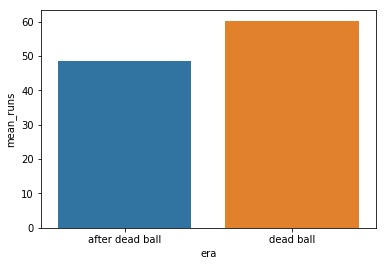

In [19]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
sns.barplot(x = "era", y="mean_runs", data=mean_runs)

## <font color="red"> Exercise 3 </font>

Compose the two queries into one piped expression

In [20]:
# Your code here

## Grouping by more than one category

* `group_by` accepts multiple columns
* Groups all combinations

## Example - Find all teams with 100+ wins in a season

#### `pandas` + `dfply`

In [21]:
(pitching
 >> select(X.yearID, X.teamID, X.W)
 >> group_by(X.yearID, X.teamID)
 >> summarise(total_wins = X.W.sum())
 >> ungroup
 >> filter_by(X.total_wins >= 100)
 >> arrange(X.yearID, X.total_wins, ascending=False)
 >> head
)

,teamID,yearID,total_wins
2848,LAN,2017,104
2842,CLE,2017,102
2845,HOU,2017,101
2810,CHN,2016,103
2800,SLN,2015,100


## So Iverson ... what's up with the `ungroup`?

* `pandas` messes with the `df.index` to group
* `dfply` adds a `_group_by` attribute to make this work without reindexing
* `ungroup` clears this attribute
* Do this before manipulating the resulting `df`

In [22]:
import numpy as np
df = pd.DataFrame({'group': ['A', 'B', 'C'],
                   'value': [1,2,3]
                  })
(df
 >> group_by(X.group))._grouped_by

['group']

In [23]:
(df
 >> group_by(X.group)
 >> ungroup)._grouped_by

## 100+ Wins in `sqlalchemy`

* Create a new column $\rightarrow$ make a new table
* Can't save the table
    * pollutes the `db`
* The solution is a subquery

## Subquery workflow

* create the query that aggregates
* give is an alias(**important!!**)
* test it
* create the query that uses the new column
    * using the first query as the "table"

#### Step 1 - Aggregate the total wins

In [24]:
total_wins = (select_sql([Pitching.yearID, 
                          Pitching.teamID, 
                          func.sum(Pitching.W).label('total_wins')])
              .group_by(Pitching.yearID, Pitching.teamID)
              .alias('total_wins')
             )

pd.read_sql_query(total_wins, con=pitching_eng).head()

,yearID,teamID,total_wins
0,1871,BS1,20
1,1871,CH1,19
2,1871,CL1,10
3,1871,FW1,6
4,1871,NY2,16


#### Step 2 - filter and sort

Pretend like the first statement is actually a table.

In [25]:
from sqlalchemy import desc
over_100_wins = (select_sql([total_wins.c.yearID,
                             total_wins.c.teamID,
                             total_wins.c.total_wins])
                .select_from(total_wins)
                .where(total_wins.c.total_wins >= 100)
                .order_by(desc(total_wins.c.yearID), desc(total_wins.c.total_wins))
                )
pd.read_sql_query(over_100_wins, con=pitching_eng).head()

,yearID,teamID,total_wins
0,2017,LAN,104
1,2017,CLE,102
2,2017,HOU,101
3,2016,CHN,103
4,2015,SLN,100


## Subqueries exposed

The inner query is embedded in the `FROM` clause with an alias

In [26]:
from sqlparse import format
print(format(str(total_wins),
             reindent=True, 
             keyword_case='upper'))

SELECT pitching."yearID",
       pitching."teamID",
       sum(pitching."W") AS total_wins
FROM pitching
GROUP BY pitching."yearID",
         pitching."teamID"


In [27]:
pprint(total_wins)

TypeError: 'module' object is not callable

In [28]:
print(format(str(over_100_wins),
             reindent=True, 
             keyword_case='upper'))

SELECT total_wins."yearID",
       total_wins."teamID",
       total_wins.total_wins
FROM
  (SELECT pitching."yearID" AS "yearID",
          pitching."teamID" AS "teamID",
          sum(pitching."W") AS total_wins
   FROM pitching
   GROUP BY pitching."yearID",
            pitching."teamID") AS total_wins
WHERE total_wins.total_wins >= :total_wins_1
ORDER BY total_wins."yearID" DESC,
         total_wins.total_wins DESC


#### `pyspark`

In [29]:
(pitching_spark
 .select([pitching_spark.yearID, 
         pitching_spark.teamID, 
         pitching_spark.W])
 .groupby(pitching_spark.yearID, 
           pitching_spark.teamID)
 .agg(fn.sum(pitching_spark.W).alias('total_wins'))
 .where(fn.col('total_wins') >= 100)
 .orderBy(pitching_spark.yearID, fn.col('total_wins'), ascending=False)
 .collect()
) >> to_pandas >> head

,yearID,teamID,total_wins
0,2017,LAN,104
1,2017,CLE,102
2,2017,HOU,101
3,2016,CHN,103
4,2015,SLN,100


## Using `group_by` in `pyspark.sql`

In [ ]:
era = (fn.when(fn.col('yearID') > 1920, "dead ball")
               .otherwise('after dead ball'))
(pitching_spark
 .select(pitching_spark.R, 
         pitching_spark.yearID)
 .where((pitching_spark.yearID >= 1900) & (pitching_spark.yearID < 1940))
 .withColumn('era', 
             (fn.when(fn.col('yearID') < 1920, "dead ball")
                .otherwise('after dead ball')))
 .groupby('era')
 .agg(fn.mean(pitching_spark.R).alias('mean_runs'))
 .collect()) >> to_pandas

## <font color="red"> Exercise 4 </font>

The query is pretty complicated.  Let's refactor the expression to improve readability.

1. Move the `when` expression out of the main query, assign it to a good name, then use the new name in the main query.
2. Do something similar with the expression inside the `where` and `agg` clauses.

In [ ]:
# Your refactored code here

## Creating new columns in `SQL`

In `SQL`

* **Complication:** Creating a new column $\rightarrow$ make a new table
* **Problem:** Don't want to "save" temporary tables to the `db`
* **Solution:** Embed the new table as a subquery


## Using `group_by` in `sqlalchemy` 

To solve this problem, we

* Write a subquery to construct a temporary table
* Write an outer query that `select_from` the subquery

#### Step 1 - Make and test the inner subquery

**Note:** Notice that we give this query an alias, which will allow the outer query to refer to this table.

In [ ]:
from sqlalchemy import and_, case

inner = (select_sql([Pitching.yearID, 
                     Pitching.R,
                     case([(Pitching.yearID < 1920, 'dead ball')],
                         else_='after dead ball'
                     ).label('era')
                    ])
         .where(and_(Pitching.yearID >= 1900,
                     Pitching.yearID < 1940))
        ).alias('w')
print(inner)

In [ ]:
pd.read_sql_query(inner, con=pitching_eng).head()

#### Step 2 - Create the outer select expression

Note that we can treat the inner query as a table and reference the columns using e.g. `inner.c.era`.

In [ ]:
outer = (select_sql([inner.c.era, 
                     func.avg(inner.c.R)])
         .group_by(inner.c.era))
print(outer)

In [ ]:
pd.read_sql_query(outer, con=pitching_eng)

## <font color="red"> Exercise 5 </font>

The inner subquery is pretty complicated.  Let's refactor the expression to improve readability.

1. Move the `case` expression out of the main query, assign it to a good name, then use the new name in the main query.
2. Do something similar with the expression inside the `where` clause.

In [ ]:
# Your refactored code here

## The last comparison might not be fair

Comparison is only fair if pitchers all pitch the same number of outs/games/innings.  Let's see if there is a difference between the eras in terms of outs pitched (`IPouts`).

In [ ]:
mean_outs = (pitching
             >> select(X.IPouts, X.yearID)
             >> filter_by((X.yearID >= 1900) & (X.yearID < 1940))
             >> mutate(era = ifelse(X.yearID < 1920, 
                                    "dead ball", 
                                    "after dead ball"))
             >> group_by(X.era)
             >> summarise(mean_outs = mean(X.IPouts)))
mean_outs

In [ ]:
sns.barplot(x = "era", y="mean_outs", data=mean_outs)

## A more fair comparison

Instead of comparing the era's on a per-pitcher basis, let's compare on a per year basis.  We will

1. Compute the total runs and total IPouts per year.
2. Compute the ratio of these totals for each year.
3. Compute the average value of the ratio for each era

In [ ]:
mean_runs_per_out = (pitching
                     >> select(X.IPouts, X.yearID, X.R)
                     >> filter_by((X.yearID >= 1900) & (X.yearID < 1940))
                     >> group_by(X.yearID)
                     >> summarise(total_runs = X.R.sum(),
                                  total_ipouts = X.IPouts.sum())
                     >> ungroup
                     >> mutate(runs_per_out = X.total_runs/X.total_ipouts,
                               era = ifelse(X.yearID < 1920, 
                                            "dead ball", 
                                            "after dead ball"))
                     >> group_by(X.era)
                     >> summarise(mean_runs_per_out = mean(X.runs_per_out))
                    )
mean_runs_per_out

In [ ]:
sns.barplot(x = "era", y="mean_runs_per_out", data=mean_runs_per_out)

## <font color="red"> Exercise 6 </font>

It would be easier to understand this result if we were computing runs on a per-game basis.  Redo the last problem, both this time compute `mean_runs_per_9_innings`.  **Hint:** There are 27 outs in a 9 inning game.

In [ ]:
# Your code here

## <font color="red"> Exercise 7 </font>

Perform the same computations in `sqlalchemy` and `pyspark`

In [ ]:
# Your code here

## <font color="red"> Exercise 6 </font>

Compute and plot the average home runs per game allowed per year for all years in the pitching table.  To accomplish this task, you should

1. Aggregate total `HR` and `IPouts` for each year.
1. Create a `games_pitched`, which is computed by dividing total inning pitched outs `IPouts` by 27, the number of outs in a game.
2. Create a `hr_per_game` column by dividing the total `HR` for each year by `games_pitched` for each year.
4. Make line plot of the results. You will need to create a new column `HR_per_inning` then perform the group and aggregate. You can use [seaborn's lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html) to make the graph.

In [ ]:
# Your refactored code here

## Up next

Pivot tables